## Flood Vulnerability Index (FVI) Assessment 1

In [1]:
import os
import sys
from functools import reduce
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import geopandas as gpd
import rasterio
import fhv
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# ADMINISTRATIVE SHAPEFILE
# ------------------------------------------------- #
# Upazila
shape3 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'] = f45t30.values
shape3['ADM3_PCODE'] = shape3['ADM3_PCODE'].astype(int)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape3['ADM2_PCODE'] = shape3['ADM2_PCODE'].astype(int)
shape3 = shape3.drop(shape3.columns[[0,1,4,5,6,9,10,11,12,13,14,15]], axis=1)
ADM2 = shape3[['ADM2_EN','ADM2_PCODE']].copy().drop_duplicates()
ADM2['ADM2_PCODE'] = ADM2['ADM2_PCODE'].astype(int)
# District
shape2 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm2_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
shape2 = shape2.drop(shape2.columns[[0,1,4,5,6,9,10,11,12,13]], axis=1)
f45t30 = '30' + shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape2['ADM2_PCODE'] = shape2['ADM2_PCODE'].astype(int)
# Division
shape1 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm1_bbs_20180410.shp')
# ------------------------------------------------- #

In [2]:
# Load data
data = pd.read_hdf('./data/data.hdf')
data_dist = pd.read_hdf('./data/data_dist.hdf')
data_table = pd.read_hdf('./data/data_table.hdf')
# Add a dot to the district variables
name_dot = data_table['Name'].copy()
name_dot[data_table['Scale'] == "District"] = name_dot[data_table['Scale'] == "District"] + '*'

# Label short names
data_table_temp = data_table.copy()
data_table_temp['Domain'] = data_table_temp['Domain'].replace({'Demographic':'DEMO', 
                                                               'Health':'HEALTH',
                                                               'Social':'SOCIAL',
                                                               'Adaptive Capacity':'COPING CAPACITY',
                                                               'Economic':'ECON',
                                                               'Built':'BUILT'})
data = data[data_table['Name']]

# Re-group to three groups
data_table['Domain'] = data_table['Domain'].replace({'Demographic':'SOCIO-ECONOMIC', 
                                                     'Built':'SOCIO-ECONOMIC', 
                                                     'Social':'SOCIO-ECONOMIC',
                                                     'Economic':'SOCIO-ECONOMIC',
                                                     'Health':'HEALTH',
                                                     'Adaptive Capacity':'COPING CAPACITY'})
domains = data_table['Domain'].unique()
ndm = len(domains)
nvar = np.array([(data_table['Domain'] == dm).sum() for dm in domains])
ndist = data.shape[0]

### (1) Correlation Matrix

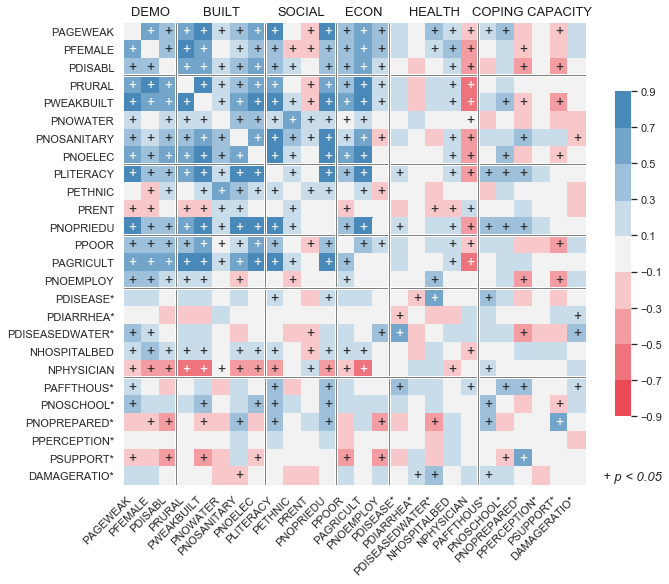

In [3]:
# Correlation Matrix and P-value
corrmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
pvalmat = data[data.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
corrmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[0])
pvalmat_dist = data_dist[data_dist.columns].corr(method=lambda x, y: pearsonr(x, y)[1])
# P-value symbols
pvalsym = pd.DataFrame(index=corrmat.index, data=np.full(corrmat.shape, ''), 
                       columns=corrmat.columns)
pvalsym[pvalmat <= 0.05] = '+'
pvalsym_dist = pd.DataFrame(index=corrmat_dist.index, data=np.full(corrmat_dist.shape, ''), 
                            columns=corrmat_dist.columns)
pvalsym_dist[pvalmat_dist <= 0.05] = '+'
# - Replace Upazila correaltions to District correlation for district-level variables
index = data_table[data_table['Scale'] == 'District'].index
corrmat.iloc[index,:] = corrmat_dist.iloc[index,:]
corrmat.iloc[:,index] = corrmat_dist.iloc[:,index]
corrmat[np.eye(len(corrmat)).astype('bool')] = 0
pvalsym.iloc[index,:] = pvalsym_dist.iloc[index,:]
pvalsym.iloc[:,index] = pvalsym_dist.iloc[:,index]
pvalsym[np.eye(len(pvalsym)).astype('bool')] = ''
# - Replace name_dot
corrmat.columns = name_dot; corrmat.index = name_dot
corrmat.index.name = ''
corrmat.columns.name = ''

# Plotting
sns.set(style="white", font_scale=1)
cmap=sns.diverging_palette(10, 240, l=55, n=9)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corrmat, ax=ax, vmin=-0.9, vmax=0.9, center=0,
                 annot=pvalsym, fmt='', annot_kws={"size": 14, 'ha':'center',"va":'center'},
                 cmap=cmap, square=True,
                 cbar_kws={'orientation': 'vertical', 'shrink':.5, 'ticks':np.arange(-0.9,1,0.2)})   # [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]})

# Domains
sources = data_table_temp['Domain'].tolist()
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        # Domain lines
        ax.axhline(i-0.05, c="w", lw=3)
        ax.axhline(i-0.05, c="grey", lw=1)
        ax.axvline(i-0.05, c="w", lw=3)
        ax.axvline(i-0.05, c="grey", lw=1)
    if source != sources[i - 1]:
        # Domain names
        lx = np.arange(len(corrmat))[np.isin(sources, source)]
        ax.annotate(source, [np.median(lx)+0.5, -0.4], 
                    xycoords='data', annotation_clip=False,
                    color='k', ha='center', fontfamily='sans-serif', fontsize=13)
        
ax.annotate('+ p < 0.05', [1.1,0.01], xycoords= 'axes fraction',ha='center', fontfamily='sans-serif', fontsize=13, style='italic')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.tight_layout()
plt.show()

# Save a figure
if False:
    fn_save = './figures/corrmat.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### (2) PCA analysis
Here, we reduce the dimensions of the three groups: Socio-economic (DEMO, BUILT, SOCIAL, ECONOMIC), Health, and Adaptive capacity.

In [4]:
# Split to the domain-level data
data1 = data[data_table.loc[data_table['Domain'] == 'SOCIO-ECONOMIC', 'Name']]
data2 = data[data_table.loc[data_table['Domain'] == 'HEALTH', 'Name']]
data3 = data[data_table.loc[data_table['Domain'] == 'COPING CAPACITY', 'Name']]
zdata1 = StandardScaler().fit_transform(data1)
zdata2 = StandardScaler().fit_transform(data2)
zdata3 = StandardScaler().fit_transform(data3)

# SoVI with varimax rotation
pca_domain = np.zeros([ndist,ndm])
# SoVI computation
# - Socio-economic
pca = fhv.SPSS_PCA(data1, reduce=True, varimax=True)
scores1, weights1 = pca.scores_rot, pca.weights_rot
comp_mat1, sumsqload1 = pca.comp_mat_rot, pca.sum_sq_load_rot
pca_domain[:,0] = scores1.sum(1)
# - Health
pca = fhv.SPSS_PCA(data2, reduce=True, varimax=True)
scores2, weights2 = pca.scores_rot, pca.weights_rot
comp_mat2, sumsqload2 = pca.comp_mat_rot, pca.sum_sq_load_rot
pca_domain[:,1] = scores2.sum(1)
# - ADAPTIVE CAPACITY
pca = fhv.SPSS_PCA(data3, reduce=True, varimax=True)
scores3, weights3 = pca.scores_rot, pca.weights_rot
comp_mat3, sumsqload3 = pca.comp_mat_rot, pca.sum_sq_load_rot
pca_domain[:,2] = scores3.sum(1)

# Selected Principal Components in each domain
scores = np.hstack([scores1,scores2,scores3])
domain_pcs = pd.DataFrame(StandardScaler().fit_transform(scores), index=data.index.astype('int'), 
                          columns=['pc11','pc12','pc13','pc21','pc22','pc31','pc32','pc33'])
map_pcs = pd.merge(shape3, domain_pcs, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')

### (3) Vulnerability Assessments
- (a) Equal-weights vulnerability
- (b) PCA vulnerability

In [5]:
# Empty vulnerability dataframe
vuln = pd.DataFrame(index=data.index.astype('int'))
# (a) Equal-weights vulnerability
equal_domain = np.zeros([data.shape[0],ndm])
for i, dm in enumerate(domains):
    target = data_table['Domain'] == dm
    ewgt = 1/target.sum()
    equal_domain[:,i] = np.dot(data[data_table[target].Name], np.full([target.sum(),1],ewgt)).flatten()
equal_scaled = QuantileTransformer(ndist).fit_transform(equal_domain)
equal_scaled = pd.DataFrame(equal_scaled, index=data.index.astype('int'), columns=['equal1','equal2','equal3'])
vuln = pd.concat([vuln, equal_scaled], axis=1)
vuln['equal'] = equal_scaled.mean(1)
# (b) PCA vulnerability
pca_scaled = QuantileTransformer(n_quantiles=10).fit_transform(pca_domain)
pca_scaled = pd.DataFrame(pca_scaled, index=data.index.astype('int'), columns=['pca1','pca2','pca3'])
vuln = pd.concat([vuln, pca_scaled], axis=1)
vuln['pca'] = pca_scaled.mean(1)
# Save unscaled domain vulnerability
pca_domain = pd.DataFrame(pca_domain, index=data.index.astype('int'), columns=['pca1','pca2','pca3'])
equal_domain = pd.DataFrame(equal_domain, index=data.index.astype('int'), columns=['equal1','equal2','equal3'])
vuln_domain = pd.concat([equal_domain, pca_domain], axis=1)
# - Standardization
vuln_domain = pd.DataFrame(data=StandardScaler().fit_transform(vuln_domain),index=data.index.astype('int'),columns=vuln_domain.columns)

# Merge with shapefile
map_domain = pd.merge(shape3, vuln_domain, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')
map_vuln = pd.merge(shape3, vuln, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')

# Save Vulnerability
fn = './data/vuln_calculated_adm3.hdf'
vuln.to_hdf(fn, 'data'); print('%s is saved.' % fn)

./data/vuln_calculated_adm3.hdf is saved.


In [6]:
temp = pd.merge(domain_pcs, vuln, left_index=True, right_index=True)
temp.corr().round(2)

,pc11,pc12,pc13,pc21,pc22,pc31,pc32,pc33,equal1,equal2,equal3,equal,pca1,pca2,pca3,pca
pc11,1.00,0.00,0.00,0.12,-0.51,-0.02,0.34,-0.34,0.87,-0.13,0.17,0.51,0.49,-0.25,0.00,0.16
pc12,0.00,1.00,-0.00,-0.18,0.08,-0.04,-0.09,-0.11,0.28,-0.10,-0.16,0.02,0.43,-0.09,-0.14,0.13
pc13,0.00,-0.00,1.00,0.11,-0.04,-0.48,-0.04,-0.08,0.05,0.09,-0.35,-0.12,0.66,0.08,-0.34,0.24
pc21,0.12,-0.18,0.11,1.00,-0.00,-0.28,0.22,-0.02,0.08,0.69,-0.07,0.39,0.10,0.76,-0.06,0.48
pc22,-0.51,0.08,-0.04,-0.00,1.00,0.01,0.04,0.31,-0.32,0.48,0.08,0.14,-0.18,0.58,0.19,0.36
pc31,-0.02,-0.04,-0.48,-0.28,0.01,1.00,-0.00,0.00,-0.09,-0.23,0.66,0.19,-0.37,-0.23,0.58,-0.00
pc32,0.34,-0.09,-0.04,0.22,0.04,-0.00,1.00,-0.00,0.33,0.27,0.70,0.73,0.15,0.20,0.58,0.59
pc33,-0.34,-0.11,-0.08,-0.02,0.31,0.00,-0.00,1.00,-0.26,0.17,0.09,-0.00,-0.21,0.18,0.56,0.33
equal1,0.87,0.28,0.05,0.08,-0.32,-0.09,0.33,-0.26,1.00,-0.06,0.12,0.59,0.67,-0.15,-0.00,0.32
equal2,-0.13,-0.10,0.09,0.69,0.48,-0.23,0.27,0.17,-0.06,1.00,0.04,0.55,0.03,0.91,0.11,0.64


In [16]:
vuln_domain2 = QuantileTransformer(n_quantiles=10).fit_transform(vuln_domain)
vuln_domain2 = pd.DataFrame(data=StandardScaler().fit_transform(vuln_domain2),index=data.index.astype('int'),columns=vuln_domain.columns)
map_domain2 = pd.merge(shape3, vuln_domain2, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')

In [20]:
vuln_domain2 - vuln_domain

,equal1,equal2,equal3,pca1,pca2,pca3
ADM3_PCODE,,,,,,
100409,0.102928,0.061755,-0.051628,0.250769,-0.121273,0.332155
100419,-0.410137,0.084986,-0.051628,0.110455,-0.123030,0.332155
100428,-0.306622,0.069096,-0.051628,0.309833,-0.138888,0.332155
100447,-0.360970,0.132695,-0.051628,0.304675,-0.077498,0.332155
100485,-0.031245,0.013846,-0.051628,0.060598,-0.187194,0.332155
...,...,...,...,...,...,...
609141,0.087010,0.174895,0.122624,-0.368264,0.068619,0.110380
609153,0.419391,0.187177,0.122624,0.037654,0.086714,0.110380
609159,0.346480,-0.028249,0.122624,-0.925261,-0.044680,0.110380


### Mapping Domain-level Vulnerabilities (Equal-weight and PCA)

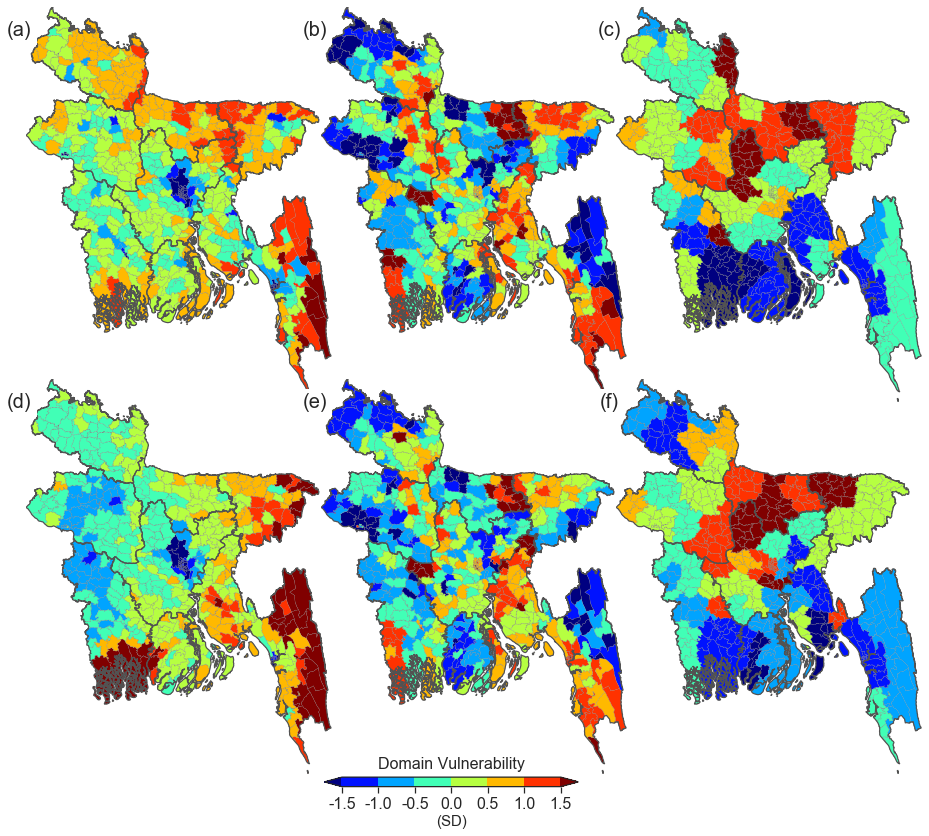

In [22]:
# Colormap
bounds = list(np.arange(-1.5,1.6,0.5))
boundaries = [-10]+bounds+[110]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'jet', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)','(b)','(c)','(d)','(e)','(f)']
figlabel = 'Domain Vulnerability'
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,10), facecolor='w')
for (i, el) in enumerate(['equal1','equal2','equal3','pca1','pca2','pca3']):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    map_domain.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.2, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.02, 0.94), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20, backgroundcolor="w")
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-0.95, -0.03, 1.8, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=16)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center')
cbar.ax.annotate('(SD)', xy=(0.5,-3.7),xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15)
plt.show()

# Save a figure
if False:
    fn_save = './figures/vulnerability_domain.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### Mapping Vulnerabilities

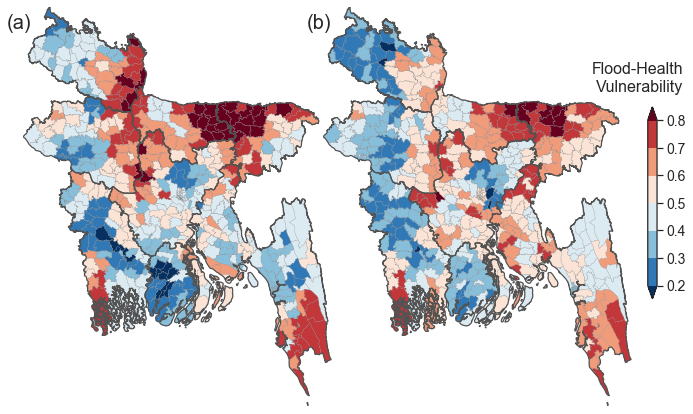

./figures/vulnerability.png is saved.


In [49]:
# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'RdBu_r', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)']
figlabel = 'Flood-Health\nVulnerability'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,5), facecolor='w')
for (i, el) in enumerate(['equal','pca']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    map_vuln.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                     linewidth=0.2, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.01, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="5%", height="40%",
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0.27, 0.6, 1.2),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='vertical')
cbar.ax.set_yticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=14)
cbar.ax.annotate(figlabel, xy=(3.8, 1.15), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='center',
                fontname='arial',fontsize=16)    

plt.show()

# Save a figure
if True:
    fn_save = './figures/vulnerability.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### Selected Principal Components in the Socio-economic domain

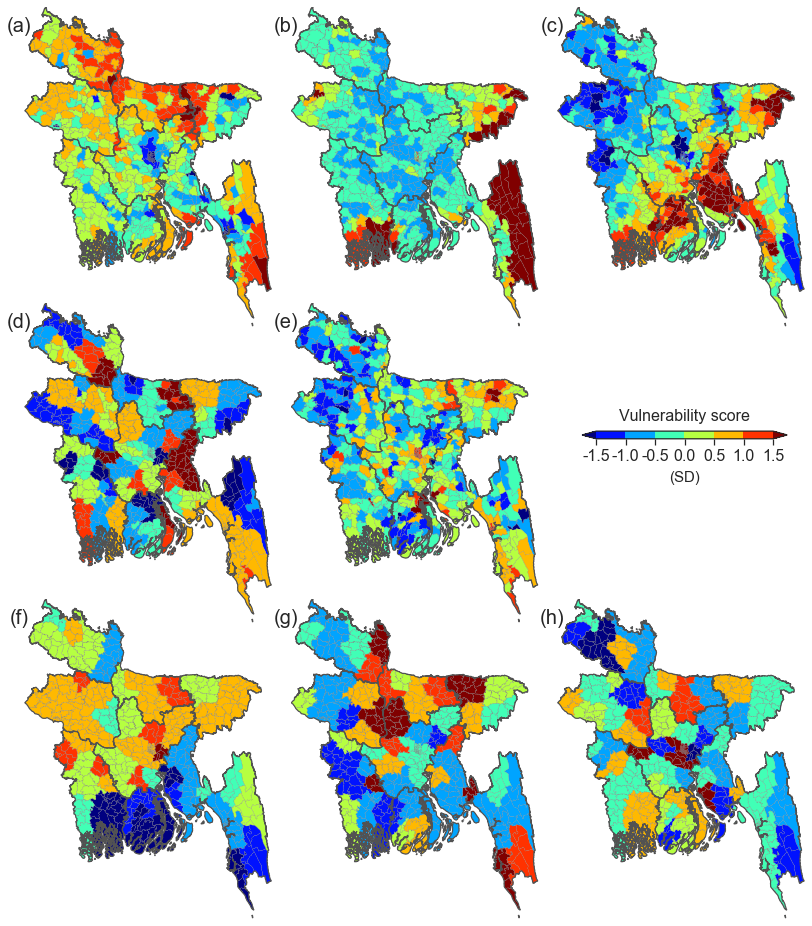

./figures/vulnerability_pca.png is saved.


In [7]:
# Colormap
bounds = list(np.arange(-1.5,1.6,0.5))
boundaries = [-10]+bounds+[110]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'jet', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)','(b)','(c)','(d)','(e)','','(f)','(g)','(h)']
figlabel = 'Vulnerability score'
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(11,12), facecolor='w')
for (i, el) in enumerate(['pc11','pc12','pc13','pc21','pc22','pc23','pc31','pc32','pc33']):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    if i != 5:
        map_pcs.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.2, edgecolor='grey')
        ax.annotate(fignumb[i], xy=(-0.02, 0.94), xycoords='axes fraction',
                    horizontalalignment='center', verticalalignment='center',
                    fontname='arial',fontsize=20)
        shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(0.1, 1.5, 1.8, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=16)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center')
cbar.ax.annotate('(SD)', xy=(0.5,-5),xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15)
plt.show()

# Save a figure
if True:
    fn_save = './figures/vulnerability_pca.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)